In [1]:
import multiprocessing as mp
import time
import os
import gc
import datetime
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import log_loss, auc, roc_curve, f1_score, average_precision_score, mean_squared_error
from sklearn.model_selection import StratifiedKFold
import catboost as cat

from reduce_memory import reduce_numeric_mem_usage, reduce_object_mem_usage

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# final = pd.read_csv('./data/final.csv')
# final.to_hdf('./data/final.h5', key='final', mode='w')

In [ ]:
final = pd.read_hdf('./data/final.h5', key='final')

In [ ]:
# train = pd.read_csv('./data/train.csv')

In [ ]:
# train['ts'] = train['timestamp'].apply(lambda t: datetime.datetime.utcfromtimestamp(t))

In [ ]:
# train_sids = train[train.ts <= datetime.datetime(2018,11,6)].session_id.unique()

In [ ]:
# final.head()

In [ ]:
# train.head()

In [ ]:
# %%time
# xtrain = final[final.session_id.isin(train_sids)].reset_index(drop=True)
# xval = final[~final.session_id.isin(train_sids)].reset_index(drop=True)

In [ ]:
len(xtrain)

In [ ]:
len(xval)

In [ ]:
del final
gc.collect()

In [3]:
%%time
xtrain = pd.read_hdf('./data/train.h5', 'xtrain')

CPU times: user 1.66 s, sys: 3.77 s, total: 5.44 s
Wall time: 5.49 s


In [4]:
%%time
xval = pd.read_hdf('./data/train.h5', 'xval')

CPU times: user 376 ms, sys: 723 ms, total: 1.1 s
Wall time: 1.1 s


In [5]:
xtrain.head(2)

,session_id,item_id,appeared,location,price,rel_price_rank,price_mean,price_median,diff_mean,diff_median,...,action_type_click_rel_pos_avg,city_nunique,city_get_first,platform_get_first,device_get_first,nfilters_mean,nfilters_max,nfilters_min,nfilters_get_last,nimps_max
0,00000510f1adc,2661832,0,0,46,0.60,27.32,20.0,18.68,26.0,...,0.0,1,"Ganpatipule, India",IN,desktop,NaN,NaN,NaN,NaN,25.0
1,00000510f1adc,9222426,0,1,26,0.76,27.32,20.0,-1.32,6.0,...,0.0,1,"Ganpatipule, India",IN,desktop,NaN,NaN,NaN,NaN,25.0


In [6]:
cat_fts = ['city_get_first', 'platform_get_first', 'device_get_first', 'item_id', 'location']
# convert to categorical
for c in cat_fts:
    print(c)
    maps = list(set(list(xtrain[c].unique()) + list(xval[c].unique())))
#     maps = xtrain[c].unique()
    mapper = dict(zip(maps, np.arange(len(maps), dtype=int)))
    xtrain[c] = xtrain[c].map(mapper)
    xval[c] = xval[c].map(mapper)


city_get_first
platform_get_first
device_get_first
item_id
location


In [7]:
reduce_numeric_mem_usage(xtrain)

Memory usage before optimization is: 7165.96 MB
Memory usage after optimization is: 2654.06 MB
Decreased by 63.0%


In [8]:
reduce_numeric_mem_usage(xval)

Memory usage before optimization is: 1534.87 MB
Memory usage after optimization is: 562.16 MB
Decreased by 63.4%


In [9]:
y_trn = xtrain['target']
y_val = xval['target']
del xtrain['target'], xval['target']

In [10]:
xtrain.head(2)

,session_id,item_id,appeared,location,price,rel_price_rank,price_mean,price_median,diff_mean,diff_median,...,action_type_click_rel_pos_avg,city_nunique,city_get_first,platform_get_first,device_get_first,nfilters_mean,nfilters_max,nfilters_min,nfilters_get_last,nimps_max
0,00000510f1adc,264592,0,0,46,0.600098,27.3125,20.0,18.687500,26.0,...,0.0,1,22560,29,2,NaN,NaN,NaN,NaN,25.0
1,00000510f1adc,363743,0,1,26,0.759766,27.3125,20.0,-1.320312,6.0,...,0.0,1,22560,29,2,NaN,NaN,NaN,NaN,25.0


In [ ]:
# xtrain.columns

In [11]:
xtrain[cat_fts].isna().sum()

city_get_first        0
platform_get_first    0
device_get_first      0
item_id               0
location              0
dtype: int64

In [12]:
xval[cat_fts].isna().sum()

city_get_first        0
platform_get_first    0
device_get_first      0
item_id               0
location              0
dtype: int64

In [13]:
xtrain.set_index('session_id', inplace=True)
xval.set_index('session_id', inplace=True)

In [14]:
params = {'iterations': 1000,
          'learning_rate': 0.02,
          'depth': 8,
          'task_type': 'CPU'}
#          'task_type': 'GPU'}

categorical_ind = [k for k, v in enumerate(xtrain.columns) if v in cat_fts ]

# train model
clf = cat.CatBoostClassifier(**params)
clf.fit(xtrain.values, y_trn,
        cat_features=categorical_ind,
        eval_set=(xval.values, y_val),
        early_stopping_rounds=100,
        verbose=100,
        plot=False)
print('Done!')
# try to save model
# model_path = './cat_model'
# cat.save_model(clf, model_path)

# saves for each fold
clfs = []
cv_scores = []
val_inds = []

# append model
clfs.append(clf)
# make prediction on validation set
val_pred = clf.predict_proba(xval)[:, 1]
logloss_i = log_loss(y_val, val_pred)
cv_scores.append(logloss_i)
# compute roc auc
fpr, tpr, thresholds = roc_curve(y_val, val_pred, pos_label=1)
auc_i = auc(fpr, tpr)
# compute map
map_i = average_precision_score(y_val, val_pred)
print('logloss={0:.4f} | map={1:.4f} | auc={2:.4f}'.format(logloss_i, map_i, auc_i))

0:	learn: 0.6540115	test: 0.6543605	best: 0.6543605 (0)	total: 16.9s	remaining: 4h 40m 48s
100:	learn: 0.1381734	test: 0.1376769	best: 0.1376769 (100)	total: 23m 20s	remaining: 3h 27m 47s
200:	learn: 0.1323298	test: 0.1325912	best: 0.1325912 (200)	total: 46m 58s	remaining: 3h 6m 45s
300:	learn: 0.1308265	test: 0.1315589	best: 0.1315589 (300)	total: 1h 12m 33s	remaining: 2h 48m 30s
400:	learn: 0.1298643	test: 0.1311353	best: 0.1311353 (400)	total: 1h 37m 11s	remaining: 2h 25m 10s
500:	learn: 0.1291045	test: 0.1307755	best: 0.1307755 (500)	total: 2h 2m 12s	remaining: 2h 1m 43s
600:	learn: 0.1285303	test: 0.1304423	best: 0.1304423 (600)	total: 2h 27m 41s	remaining: 1h 38m 3s
700:	learn: 0.1279914	test: 0.1301637	best: 0.1301637 (700)	total: 2h 52m 18s	remaining: 1h 13m 29s
800:	learn: 0.1275559	test: 0.1299577	best: 0.1299502 (797)	total: 3h 16m 54s	remaining: 48m 55s
900:	learn: 0.1271879	test: 0.1297394	best: 0.1297374 (899)	total: 3h 41m 59s	remaining: 24m 23s
999:	learn: 0.1268318	tes

In [42]:
# compute mean rr
xval['pred'] = val_pred
xval['target'] = y_val.values

In [17]:
# xtrain[train=='084dbb067c71e']
# xval.head()

In [25]:
# xval.head()

In [45]:
def reciprocal_rank(df):
    pred_list = df['pred'].values
    sorted_ind = np.argsort(pred_list)[::-1]
    ranked_items = list(df['item_id'].iloc[sorted_ind].values)
    try:
        target = df.loc[df['target']==1, 'item_id'].values[0]
        rank = ranked_items.index(target)
    except:
        return 0
    return rank+1

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 21 µs


In [46]:
%%time
val_rr = xval.groupby(level=0).apply(reciprocal_rank)

In [47]:
xtrain.shape

(15461026, 50)

In [48]:
val_rr[val_rr!=0].mean()

4.474673478239915

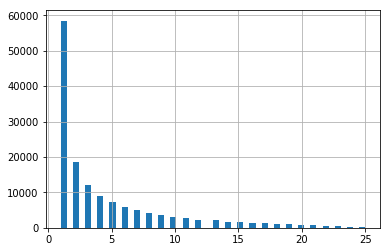

In [49]:
val_rr[val_rr!=0].hist(bins=50)

In [50]:
(1/val_rr[val_rr!=0]).mean()

0.5484640425716526

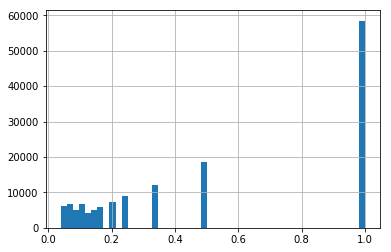

In [51]:
(1/val_rr[val_rr!=0]).hist(bins=50)